In [1]:
import os

import numpy as np
import pickle

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist

from utils import STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH, SUBJECTS, FMRI_DATA_DIR
from eval import get_distance_matrix
from data import get_fmri_data_paths, get_latent_features, LatentFeatsConfig, standardize_latents, IMAGE, CAPTION, SPLIT_TRAIN, SPLIT_TEST, SPLIT_IMAGERY, get_fmri_data, get_stim_info
from analyses.decoding.ridge_regression_decoding import get_run_str, RIDGE_DECODER_OUT_DIR, RESULTS_FILE
from feature_extraction.feat_extraction_utils import CoCoDataset
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
from preprocessing.create_gray_matter_masks import get_graymatter_mask_path
import nibabel
from PIL import Image
import pandas as pd
from IPython.display import display, HTML
from io import BytesIO
import base64


In [2]:
coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH)

In [ ]:
def resize_img(image, length=100):
    if image.size[0] < image.size[1]:
        resized_image = image.resize((length, int(image.size[1] * (length / image.size[0]))))
        required_loss = (resized_image.size[1] - length)
        resized_image = resized_image.crop(box=(0, required_loss / 2, length, resized_image.size[1] - required_loss / 2))
    else:
        resized_image = image.resize((int(image.size[0] * (length / image.size[1])), length))
        required_loss = resized_image.size[0] - length
        resized_image = resized_image.crop(box=(required_loss / 2, 0, resized_image.size[0] - required_loss / 2, length))
    return resized_image

def display_stimuli(coco_ids, imgs=True, caps=True):
    if caps:
        for coco_id in coco_ids:
            print(coco_ds.captions[coco_id], end="\n")

    if imgs:
        imgs = [np.array(resize_img(coco_ds.get_img_by_coco_id(img_id))) for img_id in coco_ids]        
        img = Image.fromarray(np.hstack(imgs))
        display(img)

def get_distance_matrix(predictions, originals, metric='cosine'):
    dist = cdist(predictions, originals, metric=metric)
    return dist
    
def dist_mat_to_pairwise_acc(dist_mat, stim_ids, print_details=False):
    diag = dist_mat.diagonal().reshape(-1, 1)
    comp_mat = diag < dist_mat
    corrects = comp_mat.sum()
    if print_details:
        for i, stim_id in enumerate(stim_ids):
            print(stim_id, end=': ')
            print(f'{comp_mat[i].sum() / (len(comp_mat[i]) - 1):.2f}')
    # subtract the number of elements of the diagonal as these values are always "False" (not smaller than themselves)
    score = corrects / (dist_mat.size - diag.size)
    return score

def dist_mat_to_rankings(dist_mat, stim_ids, candidate_set_latent_ids):
    all_ranks = []
    for test_stimulus_id, nneighbors_row in zip(stim_ids, dist_mat):
        nneighbors_ids = np.array(candidate_set_latent_ids)[np.argsort(nneighbors_row)]
        rank = np.argwhere(nneighbors_ids == test_stimulus_id)[0][0] + 1

        all_ranks.append(rank)
            
    return np.mean(all_ranks)


# Nearest Neighbors of test images

In [65]:
def load_results(betas_dir, subject, mode, feats_config, surface, mask=None):    
    # train_paths, stim_ids, stim_types = get_fmri_data_paths(betas_dir, subject, SPLIT_TRAIN, mode)    
    # train_latents = get_latent_features(feats_config, stim_ids, stim_types)
    # train_paths = np.array(train_paths)
    
    # test_paths, test_stim_ids, test_stim_types = get_fmri_data_paths(betas_dir, subject, SPLIT_TEST)
    # test_latents = get_latent_features(feats_config, test_stim_ids, test_stim_types, test_mode=True)
    # test_paths = np.array(test_paths)
    
    # train_latents, test_latents = standardize_latents(train_latents, test_latents)
    
    # gray_matter_mask_data = nibabel.load(get_graymatter_mask_path(subject)).get_fdata()
    # gray_matter_mask = gray_matter_mask_data == 1
    # print(f"Gray matter mask size: {gray_matter_mask.sum()}")
    
    run_str = get_run_str(betas_dir, feats_config, surface=surface, mask=mask)
    results_file_path = os.path.join(
        RIDGE_DECODER_OUT_DIR, mode, subject, run_str, RESULTS_FILE
    )
    print(f'loading decoder results from: \n', results_file_path)
    results = pickle.load(open(results_file_path, 'rb'))
    
    return results    
    # return stim_ids, stim_types, train_latents, gray_matter_mask, results, train_paths, test_paths

def load_betas(train_paths, test_paths):
    train_fmri_betas = []
    for idx in trange(len(train_paths), desc="loading fmri data"):
        sample = nibabel.load(train_paths[idx]).get_fdata()
        sample = sample[gray_matter_mask].astype('float32').reshape(-1)
        train_fmri_betas.append(sample)
    
    train_fmri_betas = np.array(train_fmri_betas)

    test_fmri_betas = []
    for idx in trange(len(test_paths), desc="loading fmri data"):
        sample = nibabel.load(test_paths[idx]).get_fdata()
        sample = sample[gray_matter_mask].astype('float32').reshape(-1)
        test_fmri_betas.append(sample)
    
    test_fmri_betas = np.array(test_fmri_betas)

    scaler = StandardScaler()
    scaler.fit(train_fmri_betas)
    train_fmri_betas_standardized = scaler.transform(train_fmri_betas)
    test_fmri_betas_standardized = scaler.transform(test_fmri_betas)
    
    return train_fmri_betas, test_fmri_betas, train_fmri_betas_standardized, test_fmri_betas_standardized



In [5]:
SUBJECT = 'sub-01'
MODEL = "imagebind"
SURFACE = True

# TRAINING_MODE = "images"
TRAINING_MODE = "agnostic"

BETAS_SUFFIX = 'betas'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

# feats = 'avg'
# test_feats = 'avg'
FEATS = 'default'
TEST_FEATS = 'default'
# feats = 'lang'
# test_feats = 'lang'
# vision_feats = 'vision_features_cls'
VISION_FEATS = 'default'
# vision_feats = 'n_a'

LANG_FEATS = 'default'
# lang_feats = 'lang_features_cls'
# lang_feats = 'lang_features_mean'

FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)


test_fmri_betas, test_stim_ids, test_stim_types = get_fmri_data(
    BETAS_DIR,
    SUBJECT,
    SPLIT_TEST,
    surface=SURFACE,
)
imagery_fmri_betas, imagery_stim_ids, imagery_stim_types = get_fmri_data(
    BETAS_DIR,
    SUBJECT,
    SPLIT_IMAGERY,
    surface=SURFACE,
)

train_latents = get_latent_features(FEATS_CONFIG, SUBJECT, SPLIT_TRAIN, mode=TRAINING_MODE)
test_latents = get_latent_features(FEATS_CONFIG, SUBJECT, SPLIT_TEST)
imagery_latents = get_latent_features(FEATS_CONFIG, SUBJECT, SPLIT_IMAGERY)

train_latents, test_latents, imagery_latents = standardize_latents(
    train_latents, test_latents, imagery_latents
)

results = load_results(BETAS_DIR, SUBJECT, TRAINING_MODE, FEATS_CONFIG, surface=SURFACE)

# stim_ids, stim_types, train_latents, gray_matter_mask, results, train_paths, test_paths = load(BETAS_DIR, MODEL, SUBJECT, MODE, FEATS_CONFIG)


Selected features for imagebind: avg avg vision_features_cls lang_features_cls
loading agnostic test left hemi fmri surface data.. done.
loading agnostic test right hemi fmri surface data.. done.
loading agnostic imagery left hemi fmri surface data.. done.
loading agnostic imagery right hemi fmri surface data.. done.
loading decoder results from: 
 /home/mitja/data/multimodal_decoding/whole_brain_decoding/agnostic/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls_betas_surface_fsaverage7/results.p


In [6]:
# train_fmri_betas_full, train_stim_ids, train_stim_types = get_fmri_data(
#     BETAS_DIR,
#     SUBJECT,
#     SPLIT_TRAIN,
#     TRAINING_MODE,
#     surface=SURFACE,
# )
# N_TRAIN_BETAS = 1000
# train_paths = train_paths[np.random.choice(range(len(train_paths)), size=N_TRAIN_BETAS, replace=False)]


In [7]:
# train_fmri_betas, test_fmri_betas, train_fmri_betas_standardized, test_fmri_betas_standardized = load_betas(train_paths, test_paths)

In [8]:
# def plot_betas(train_betas, test_betas, title, binwidth=3):
#     X = np.concatenate((train_betas.flatten(), test_betas.flatten()))
#     hue = ['train'] * train_betas.size + ['test'] * test_betas.size
#     plt.figure(figsize=(20, 10))
#     sns.histplot(x=X, hue=hue, binwidth=binwidth)
#     plt.title(title)

# print(np.nanmean(train_fmri_betas.mean(axis=0)))
# print(np.nanmean(test_fmri_betas.mean(axis=0)))
# print(np.nanmean(train_fmri_betas_standardized.mean(axis=0)))
# print(np.nanmean(test_fmri_betas_standardized.mean(axis=0)))

# plot_betas(train_fmri_betas, test_fmri_betas, title='unstandardized')
# plt.ylim(0, 10000000)
# plt.xlim(-25, 25)

# plot_betas(train_fmri_betas_standardized, test_fmri_betas, title='standardized', binwidth=0.3)
# plt.ylim(0, 4000000)
# plt.xlim(-3, 3)

# TSNE for Betas

In [9]:
def plot_betas_tfce(train_betas, test_betas, title, train_subset=None):
    if train_subset is not None:
        train_betas_subset = train_betas[np.random.choice(range(len(train_betas)), size=train_subset, replace=False)]
    else:
        train_betas_subset = train_betas
    train_test = np.concatenate((train_betas_subset, test_betas))
    tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, n_iter=1000)
    X_embedded = tsne.fit_transform(train_test)
    
    print(X_embedded.shape)
    assert X_embedded.shape[1] == 2
    hue = ['train'] * len(train_betas_subset) + ['test'] * len(test_betas)
    # alpha = [1] * len(test_betas) + [0.3] * len(train_betas_subset)
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(
        x = X_embedded[:, 0], y = X_embedded[:, 1],
        hue = hue,
        # alpha = alpha
    )
    plt.title(title)

plot_betas_tfce(train_fmri_betas, test_fmri_betas, title="not standardized")
plot_betas_tfce(train_fmri_betas_standardized, test_fmri_betas_standardized, "standardized")


NameError: name 'train_fmri_betas' is not defined

# TSNE for Latents

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1283 samples in 0.002s...
[t-SNE] Computed neighbors for 1283 samples in 0.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1283
[t-SNE] Computed conditional probabilities for sample 1283 / 1283
[t-SNE] Mean sigma: 1.977392
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.405090
[t-SNE] KL divergence after 1000 iterations: 1.321648
(1283, 2)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1283 samples in 0.001s...
[t-SNE] Computed neighbors for 1283 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1283
[t-SNE] Computed conditional probabilities for sample 1283 / 1283
[t-SNE] Mean sigma: 11.743058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.184052
[t-SNE] KL divergence after 1000 iterations: 1.311691
(1283, 2)


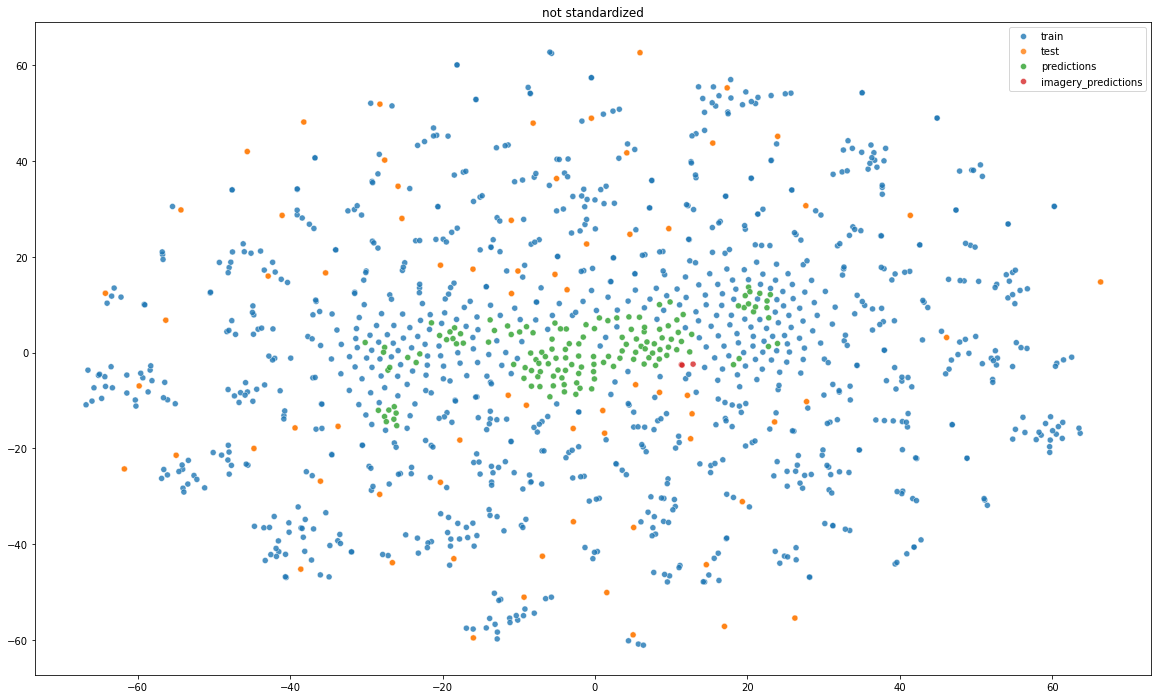

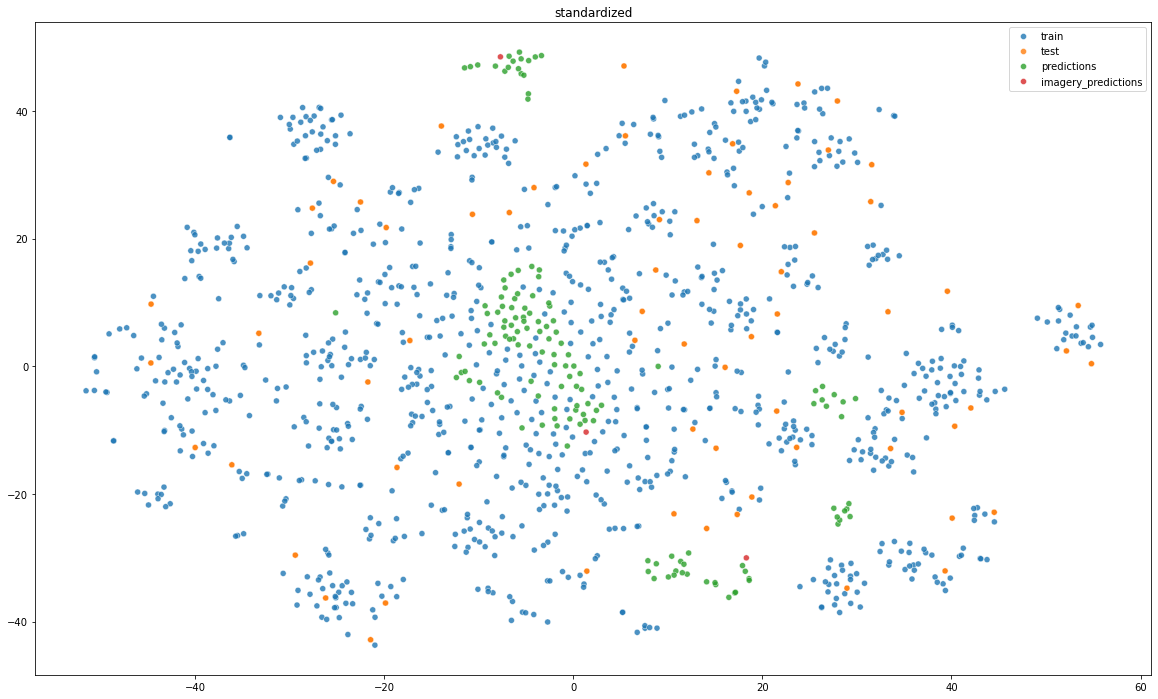

In [6]:
def plot_latents_tfce(train_lat, test_lat, pred_lat, imagery_pred_lat, title, train_subset=1000):
    train_latents_subset = train_latents[np.random.choice(range(len(train_lat)), size=train_subset, replace=False)]
    
    tsne = TSNE(n_components=2, learning_rate='auto', verbose=1, n_jobs=10, n_iter=1000)
    X_embedded = tsne.fit_transform(np.concatenate((train_latents_subset, test_lat, pred_lat, imagery_pred_lat)))
    
    print(X_embedded.shape)
    assert X_embedded.shape[1] == 2
    hue = ['train'] * len(train_latents_subset) + ['test'] * len(test_lat) + ['predictions'] * len(pred_lat) + ['imagery_predictions'] * len(imagery_pred_lat)
    # alphas = [0.3] * len(train_latents_subset) + [1] * len(test_lat) + [1] * len(preds)
    
    plt.figure(figsize=(20, 12))
    sns.scatterplot(
        x = X_embedded[:, 0], y = X_embedded[:, 1],
        hue = hue,
        alpha = 0.8
    )
    plt.title(title)

plot_latents_tfce(train_latents, results['latents'], results['predictions'], results['imagery_predictions'], title="not standardized")

pred_latents_standardized = StandardScaler().fit_transform(results['predictions'])   
imagery_pred_latents_standardized = StandardScaler().fit_transform(results['imagery_predictions'])
plot_latents_tfce(train_latents, results['latents'], pred_latents_standardized, imagery_pred_latents_standardized, "standardized")

# Nearest Neighbors with predictions averaged over subjects

In [ ]:
N_NEIGHBORS = 5
N_SAMPLES = 5


def plot_nn_table(stim_ids, nneighbors, stim_type):
    df = pd.DataFrame({'stimulus': stim_ids} | {f'rank_{i}': [n[i] for n in nneighbors] for i in range(len(nneighbors[0]))})
        
    def image_base64(img_id, length=150):
        im = resize_img(coco_ds.get_img_by_coco_id(img_id), length=length)
        with BytesIO() as buffer:
            im.save(buffer, 'jpeg')
            decoded = base64.b64encode(buffer.getvalue()).decode()
            return decoded
    
    def stimulus_formatter(img_id, width=150, height=200):
        if stim_type == IMAGE:
            formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top"><img src="data:image/jpeg;base64,{image_base64(img_id)}"></div>'
        elif stim_type == CAPTION:
            formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top">{coco_ds.captions[img_id]}</div>'
        else:
            formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top; text-align:left"><img src="data:image/jpeg;base64,{image_base64(img_id)}">'
            formatted += f'<br>{coco_ds.captions[img_id]}</div>'
        return formatted
            
    def image_and_cap_formatter(img_id, width=150, height=200):
        img = image_base64(img_id)
        formatted = f'<div style="height:{height}px; width:{width}px; vertical-align:top; text-align:left"><img src="data:image/jpeg;base64,{img}">'
        cap = coco_ds.captions[img_id]
        formatted += f'<br>{cap}</div>'
        return formatted
            
    pd.set_option('display.max_colwidth', None)
    
    custom_formatters = {'stimulus': stimulus_formatter} | {f'rank_{i}': image_and_cap_formatter for i in range(len(nneighbors[0]))}

    display(HTML(df.to_html(formatters=custom_formatters, escape=False, index=False)))


def analysis_ranking(test_preds, test_stim_ids, candidate_latents, candidate_latent_ids, stim_type, n_samples=N_SAMPLES, n_neighbors=N_NEIGHBORS):
    dist_mat = get_distance_matrix(test_preds, candidate_latents)
  
    acc = dist_mat_to_pairwise_acc(dist_mat, test_stim_ids)
    print(f'pairwise acc: {acc:.3f}')
    rank = dist_mat_to_rankings(dist_mat, test_stim_ids, candidate_latent_ids)
    # print(f'mean rank: {rank:.1f} / {dist_mat.shape[1]} ({rank/dist_mat.shape[1]:.2f})')

    np.random.seed(7)
    sampled_ids = np.random.choice(range(len(test_stim_ids)), n_samples, replace=False)
    test_stim_ids = np.array(test_stim_ids)[sampled_ids]
    dist_mat = dist_mat[sampled_ids]

    nneighbors = [np.array(candidate_latent_ids)[np.argsort(nneighbors_row)][:n_neighbors] for nneighbors_row in dist_mat]

    plot_nn_table(test_stim_ids, nneighbors, stim_type)

    return acc, rank

In [ ]:
N_NEIGHBORS = 5
N_SAMPLES = 5

WHOLE_TRAIN_SET_AS_CANDIDATE_SET = False
AVERAGE_IMG_AND_CAP_TEST_PREDS = False

MODEL = "imagebind"
# MODEL = "dino-base"

SURFACE = True

TRAINING_MODE = "agnostic"
# TRAINING_MODE = "images"
# TRAINING_MODE = "captions"

BETAS_SUFFIX = 'betas'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

RESTANDARDIZE_PREDS = True

FEATS = 'default'
TEST_FEATS = 'default'
# FEATS = 'vision'
# TEST_FEATS = 'vision'
VISION_FEATS = 'default'
LANG_FEATS = 'default'
FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

all_preds = []
all_preds_standardized = []
all_train_stim_ids = []
all_train_latents = []
for subj in SUBJECTS:
    stim_ids, _ = get_stim_info(subj, SPLIT_TRAIN)
    
    train_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TRAIN)
    test_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TEST)
    imagery_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_IMAGERY)
    
    train_latents, test_latents, imagery_latents = standardize_latents(
        train_latents, test_latents, imagery_latents
    )

    results = load_results(BETAS_DIR, subj, TRAINING_MODE, FEATS_CONFIG, surface=SURFACE)

    # stim_ids, stim_types, train_latents, gray_matter_mask, results, train_paths, test_paths = load(BETAS_DIR, MODEL, subj, MODE, FEATS_CONFIG)
  
    pred_latents = results['predictions']
   
    if RESTANDARDIZE_PREDS:
        print('standardizing predictions')
        pred_latents = StandardScaler().fit_transform(pred_latents)   

    all_preds.append(pred_latents)
    all_train_stim_ids.append(stim_ids)
    all_train_latents.append(train_latents)

all_train_stim_ids = np.concatenate(all_train_stim_ids)
all_train_latents = np.concatenate(all_train_latents)

all_preds = np.mean(all_preds, axis=0)

if AVERAGE_IMG_AND_CAP_TEST_PREDS:
    test_stim_ids_avgd = results['stimulus_ids'][results['stimulus_types'] == IMAGE]
    test_latents_avgd = np.mean([results['latents'][results['stimulus_types'] == stim_type] for stim_type in [IMAGE, CAPTION]], axis=0)
    pred_latents_avgd = np.mean([all_preds[results['stimulus_types'] == stim_type] for stim_type in [IMAGE, CAPTION]], axis=0)
    
    if WHOLE_TRAIN_SET_AS_CANDIDATE_SET:
        # account for case that sometimes both the image and the caption are part of the training set
        unique_stim_ids, indices = np.unique(all_train_stim_ids, return_index=True)
        unique_train_latents = all_train_latents[indices]
        
        candidate_latents = np.concatenate((test_latents_avgd, unique_train_latents))
        candidate_latent_ids = np.concatenate((test_stim_ids_avgd, unique_stim_ids))
    else:
        candidate_latents = test_latents_avgd
        candidate_latent_ids = test_stim_ids_avgd
    
    print('candidate set size: ', len(candidate_latent_ids))
    
    analysis_ranking(pred_latents_avgd, test_stim_ids_avgd, candidate_latents, candidate_latent_ids, 'avg_caption_image', N_SAMPLES, N_NEIGHBORS)

else:
    for stim_type in [IMAGE, CAPTION]:#, CAPTION]:
        print(f'decoding of {stim_type}s')
        test_stim_ids_mod = results['stimulus_ids'][results['stimulus_types'] == stim_type]
        test_latents_mod = results['latents'][results['stimulus_types'] == stim_type]
    
        pred_latents_mod = all_preds[results['stimulus_types'] == stim_type]
            
        if WHOLE_TRAIN_SET_AS_CANDIDATE_SET:
            # account for case that sometimes both the image and the caption are part of the training set
            unique_stim_ids, indices = np.unique(all_train_stim_ids, return_index=True)
            unique_train_latents = all_train_latents[indices]
            
            candidate_latents = np.concatenate((test_latents_mod, unique_train_latents))
            candidate_latent_ids = np.concatenate((test_stim_ids_mod, unique_stim_ids))
        else:
            candidate_latents = test_latents_mod
            candidate_latent_ids = test_stim_ids_mod
    
        analysis_ranking(pred_latents_mod, test_stim_ids_mod, candidate_latents, candidate_latent_ids, stim_type, N_SAMPLES, N_NEIGHBORS)

# Nearest neighbors of imagery trials

In [4]:
N_NEIGHBORS = 5
N_SAMPLES = 3
WHOLE_TRAIN_SET_AS_CANDIDATE_SET = True

MODEL = "imagebind"

# TRAINING_MODE = "images"
# TRAINING_MODE = "captions"
TRAINING_MODE = "agnostic"

MASK = '/home/mitja/data/multimodal_decoding/searchlight/permutation_testing_results/imagebind/default/imagebind/default/imagebind/default/fsaverage7/n_neighbors_750/results_maps/cluster_masks/cross_decoding_lh_threshold_100000.0_cluster_0'
# MASK = None

BETAS_SUFFIX = 'betas'

BETAS_DIR = os.path.join(FMRI_DATA_DIR, BETAS_SUFFIX)

RESTANDARDIZE_PREDS = True

FEATS = 'default'
TEST_FEATS = 'default'
VISION_FEATS = 'default'
LANG_FEATS = 'default'
FEATS_CONFIG = LatentFeatsConfig(MODEL, FEATS, TEST_FEATS, VISION_FEATS, LANG_FEATS)

all_pairwise_accs = []
for subj in SUBJECTS:
    print(subj)

    stim_ids, _ = get_stim_info(subj, SPLIT_TRAIN)
    
    train_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TRAIN)
    test_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_TEST)
    imagery_latents = get_latent_features(FEATS_CONFIG, subj, SPLIT_IMAGERY)
    
    train_latents, test_latents, imagery_latents = standardize_latents(
        train_latents, test_latents, imagery_latents
    )

    results = load_results(BETAS_DIR, subj, TRAINING_MODE, FEATS_CONFIG, surface=SURFACE, mask=MASK)
    
    # stim_ids, stim_types, train_latents, gray_matter_mask, results, train_paths, test_paths = load(BETAS_DIR, MODEL, subj, MODE, FEATS_CONFIG)
    
    pred_latents_imagery = results['imagery_predictions']
    if RESTANDARDIZE_PREDS:
        print('standardizing imagery predictions')
        # pred_latents = results['predictions']
        # transform = StandardScaler().fit(pred_latents)
        # pred_latents_imagery = transform.transform(pred_latents_imagery)
        pred_latents_imagery = StandardScaler().fit_transform(pred_latents_imagery)

    test_stim_ids_mod = results['stimulus_ids'][results['stimulus_types'] == IMAGE]
    test_latents_mod = results['latents'][results['stimulus_types'] == IMAGE]
        
    if WHOLE_TRAIN_SET_AS_CANDIDATE_SET:
        # account for case that sometimes both the image and the caption are part of the training set
        unique_stim_ids, indices = np.unique(stim_ids, return_index=True)
        unique_train_latents = train_latents[indices]
        
        candidate_latents = np.concatenate((results['imagery_latents'], test_latents_mod, unique_train_latents))
        candidate_latent_ids = np.concatenate((results['imagery_stimulus_ids'], test_stim_ids_mod, unique_stim_ids))
    else:
        candidate_latents = results['imagery_latents']
        candidate_latent_ids = results['imagery_stimulus_ids']

    # print(pred_latents_imagery)
    # print(results['imagery_stimulus_ids'])
    # print(candidate_latent_ids)
    acc, rank = analysis_ranking(pred_latents_imagery, results['imagery_stimulus_ids'], candidate_latents, candidate_latent_ids, CAPTION, N_SAMPLES, N_NEIGHBORS)
    all_pairwise_accs.append(acc)

print(f'Mean pairwise acc: {np.mean(all_pairwise_accs):.2f}')



Selected features for imagebind: avg avg vision_features_cls lang_features_cls
sub-01


NameError: name 'load_results' is not defined